# Train

In [144]:
# library
import pandas as pd
import numpy as np
import pathlib
import plotly.express as px
from sklearn.cluster import KMeans
import scipy
from scipy.io import arff
from scipy import signal
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import librosa
import IPython.display
import json
from tqdm import tqdm
import statistics
import random
import os
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [36]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

RANDOM_SEED = 42
seed_everything(RANDOM_SEED)

In [46]:
df_train = pd.read_csv("train.csv")
X = np.load("./train_feature.npy")

print(X.shape)
df_train.head()

(427, 143)


,arousal,valence,speaker,starttime,endtime,duration
0,0.008319,0.027559,dev_1,0.00,2.820023,2.820023
1,0.190632,0.142288,dev_1,5.79,13.200023,7.410023
2,-0.191232,-0.022424,dev_1,27.94,30.410023,2.470023
3,-0.253758,-0.063409,dev_1,33.04,33.280023,0.240023
4,0.134728,0.053930,dev_1,37.77,59.760023,21.990023


In [26]:
df_train.describe()

,arousal,valence,starttime,endtime,duration
count,427.000000,427.000000,427.000000,427.000000,427.000000
mean,-0.054713,0.084354,143.151686,150.028407,6.876721
std,0.164167,0.115745,87.256258,87.293594,10.039718
min,-0.548091,-0.161207,0.000000,0.000023,0.000023
25%,-0.177090,0.003054,63.385000,69.555023,1.110023
50%,-0.031569,0.064666,146.530000,153.690023,3.890023
75%,0.070150,0.143972,219.860000,224.625023,8.310023
max,0.355714,0.543328,297.720000,298.130023,113.340023


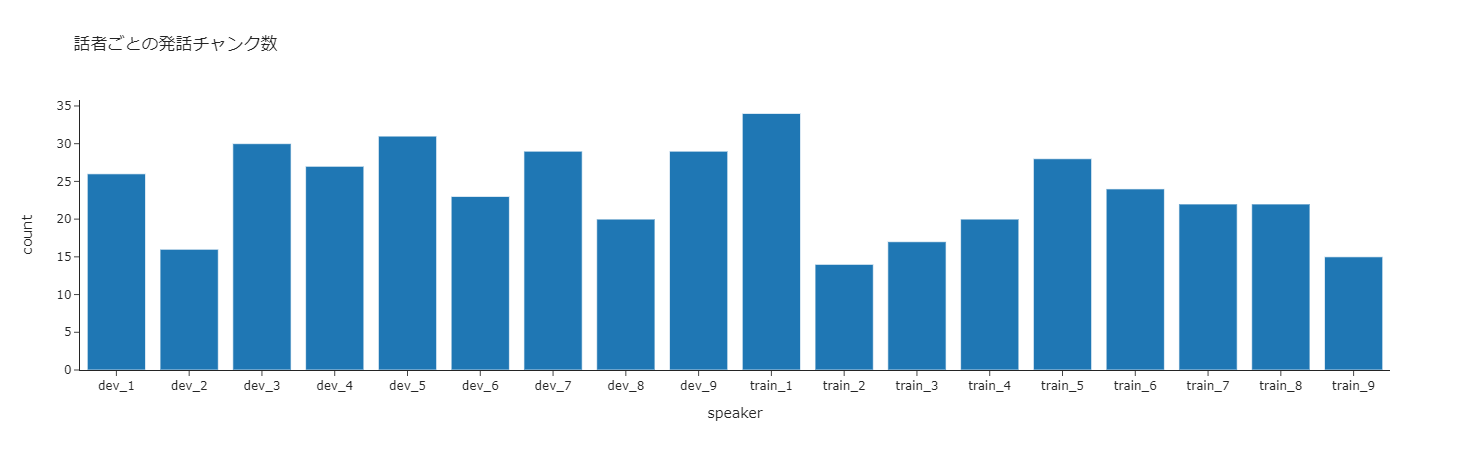

In [22]:
df_sum = df_train.groupby("speaker", as_index=False).count()[["speaker", "arousal"]].rename(columns={"arousal": "count"})
fig = px.bar(df_sum, x='speaker', y='count', template="simple_white", title="話者ごとの発話チャンク数")
fig.show()

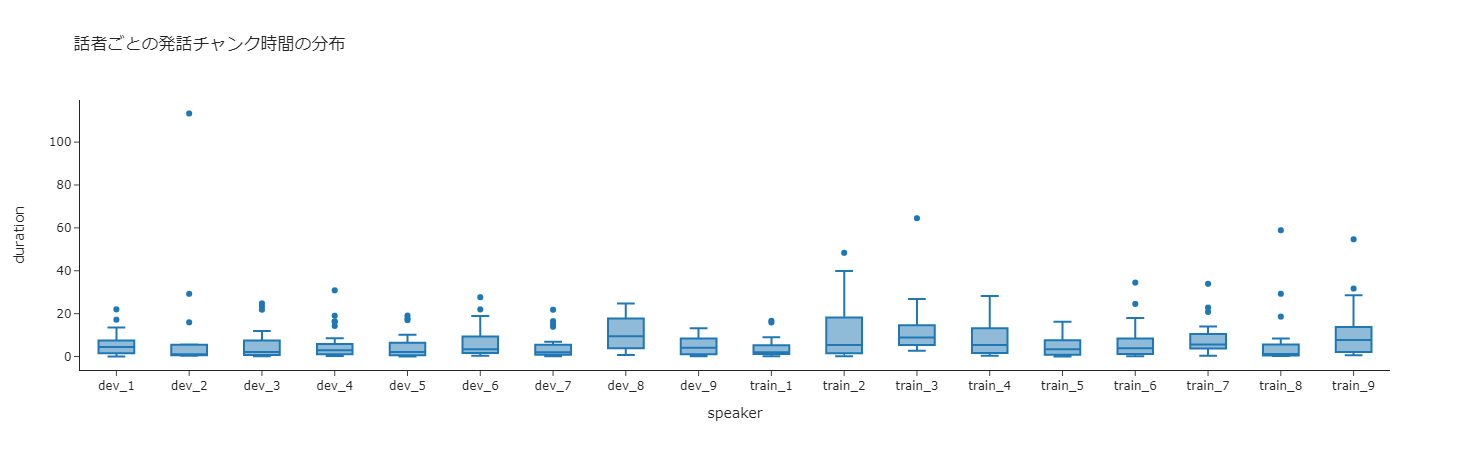

In [25]:
fig = px.box(df_train.sort_values("speaker"), x='speaker', y='duration', template="simple_white", title="話者ごとの発話チャンク時間の分布")
fig.show()

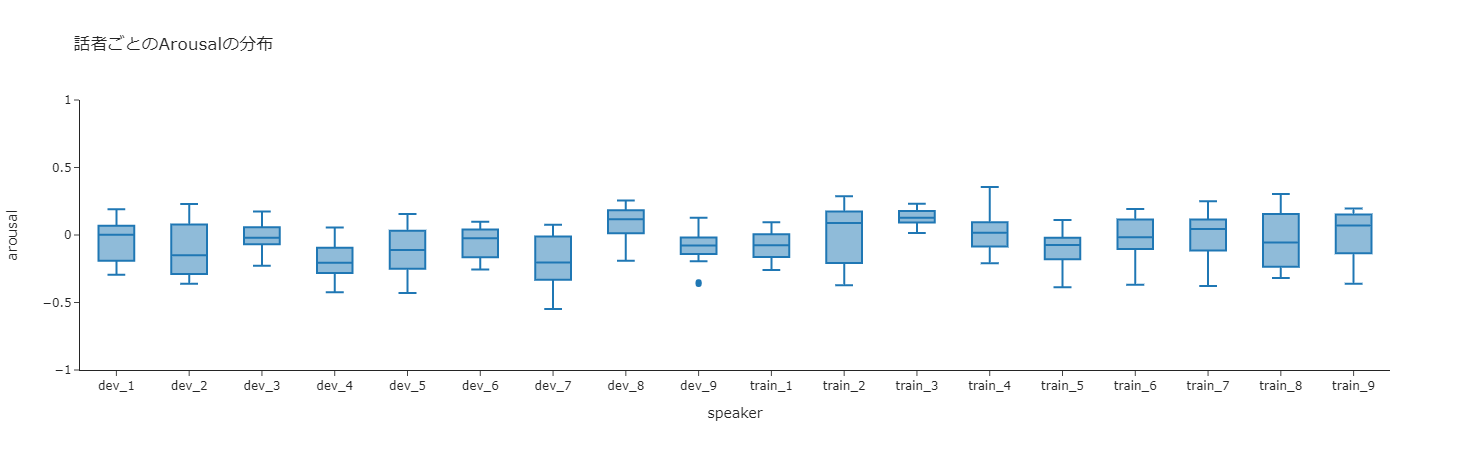

In [29]:
fig = px.box(df_train.sort_values("speaker"), x='speaker', y='arousal', template="simple_white", title="話者ごとのArousalの分布")
fig.update_yaxes(range=[-1, 1])
fig.show()

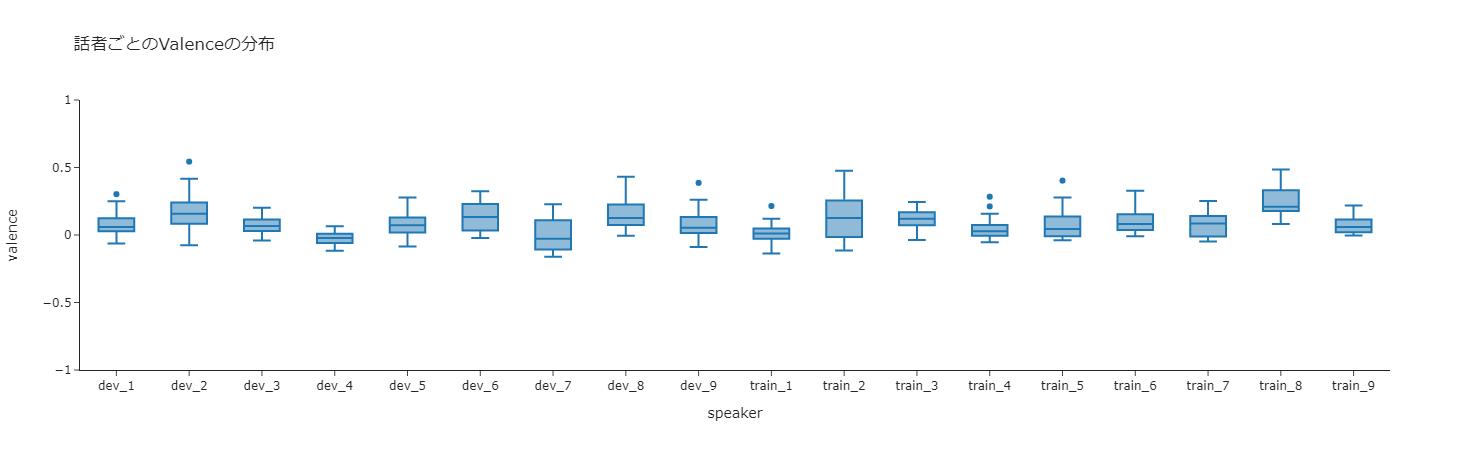

In [30]:
fig = px.box(df_train.sort_values("speaker"), x='speaker', y='valence', template="simple_white", title="話者ごとのValenceの分布")
fig.update_yaxes(range=[-1, 1])
fig.show()

## Train

In [162]:
le = LabelEncoder()
speakers = le.fit_transform(df_train.speaker.values)
y_arousal = df_train.arousal.values
y_valence = df_train.valence.values

In [163]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv, linewidth = 15,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=cmap_data, linewidth = 15,)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data, linewidth = 15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))

    # Formatting
    # yticklabels = list(range(n_splits)) + ['class', 'group']
    yticklabels = list(range(n_splits)) + ['', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(group)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

<AxesSubplot:title={'center':'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

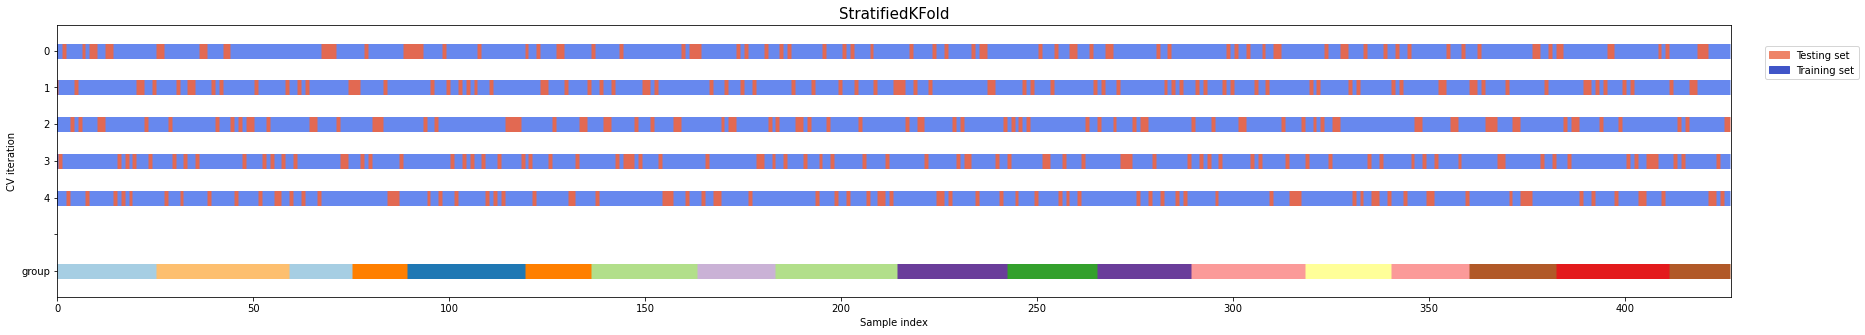

In [164]:
# Group K-fold
fig, ax = plt.subplots(figsize=(30.0, 5.0))
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
plot_cv_indices(skf, X, speakers, speakers, ax, 5)

In [165]:
# svr = SVR(kernel = "rbf",gamma = 1,C=100,epsilon = 0)
# cross_validate(svr,X,y_arousal,scoring="r2",cv=gkf, groups=speakers)

train_scores = []
valid_scores = []
oof_preds = np.zeros(len(X))

v_train_scores = []
v_valid_scores = []
v_oof_preds = np.zeros(len(X))

# arousal
for train_idx, val_idx in skf.split(X, speakers):
    svr = SVR(kernel = "rbf")
    X_train = X[train_idx]
    y_train = y_arousal[train_idx]
    X_valid = X[val_idx]
    y_valid = y_arousal[val_idx]   

    # fit
    svr.fit(X_train, y_train)
    
    # train
    train_pred = svr.predict(X_train)
    train_score = mean_absolute_error(y_train, train_pred)
    
    # valid
    oof_pred = svr.predict(X_valid)
    valid_score = mean_absolute_error(y_valid, oof_pred)
    
    # return
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    oof_preds[val_idx] = oof_pred
    
# valence
for train_idx, val_idx in skf.split(X, speakers):
    svr = SVR(kernel = "rbf")
    X_train = X[train_idx]
    y_train = y_valence[train_idx]
    X_valid = X[val_idx]
    y_valid = y_valence[val_idx]   

    # fit
    svr.fit(X_train, y_train)
    
    # train
    train_pred = svr.predict(X_train)
    train_score = mean_absolute_error(y_train, train_pred)
    
    # valid
    oof_pred = svr.predict(X_valid)
    valid_score = mean_absolute_error(y_valid, oof_pred)
    
    # return
    v_train_scores.append(train_score)
    v_valid_scores.append(valid_score)
    v_oof_preds[val_idx] = oof_pred

In [175]:
print(np.mean(train_scores))
print(np.mean(valid_scores))

0.10921233811102496
0.11508346948309103


In [176]:
print(np.mean(v_train_scores))
print(np.mean(v_valid_scores))

0.0875932411533776
0.09166841793857786


In [174]:
np.mean(train_scores)
np.mean(valid_scores)


0.10921233811102496

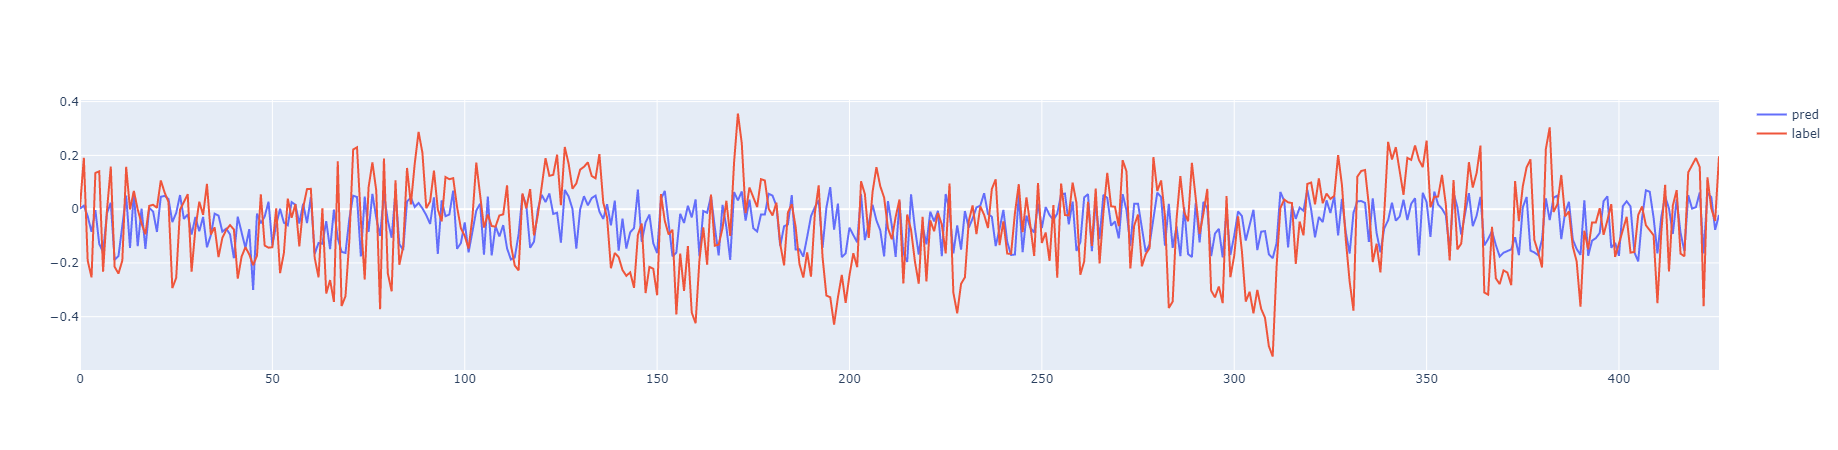

In [173]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=oof_preds,
                    mode='lines',
                    name='pred'))
fig.add_trace(go.Scatter(y=y_arousal,
                    mode='lines',
                    name='label'))
fig.show()

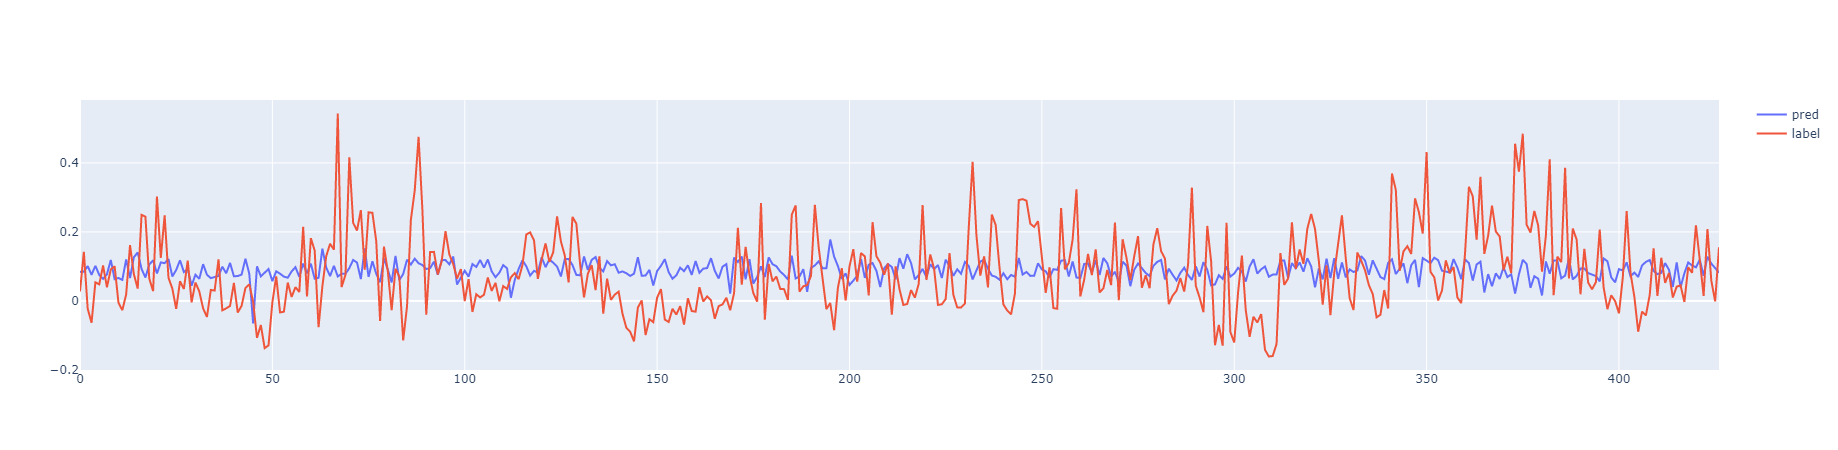

In [170]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=v_oof_preds,
                    mode='lines',
                    name='pred'))
fig.add_trace(go.Scatter(y=y_valence,
                    mode='lines',
                    name='label'))
fig.show()